### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [9]:
#Part 1
import numpy as np
import matplotlib.pyplot as plt

data = np.load('./hw_data/hw8_data_1.npy')

print("Column names:")
print(data.dtype.names)

u_g = data['u'] - data['g']  
g_r = data['g'] - data['r']  
r_i = data['r'] - data['i']  
i_z = data['i'] - data['z']  

redshift = np.array(data['redshift'])
spec_class = np.array(data['specClass'])

n_galaxies = np.sum(spec_class == 'GALAXY')
n_quasars = np.sum(spec_class == 'QSO')

print(f"Number of regular galaxies: {n_galaxies}")
print(f"Number of quasars: {n_quasars}")
print(f"Total objects: {len(data)}")


Column names:
('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Number of regular galaxies: 42808
Number of quasars: 7192
Total objects: 50000


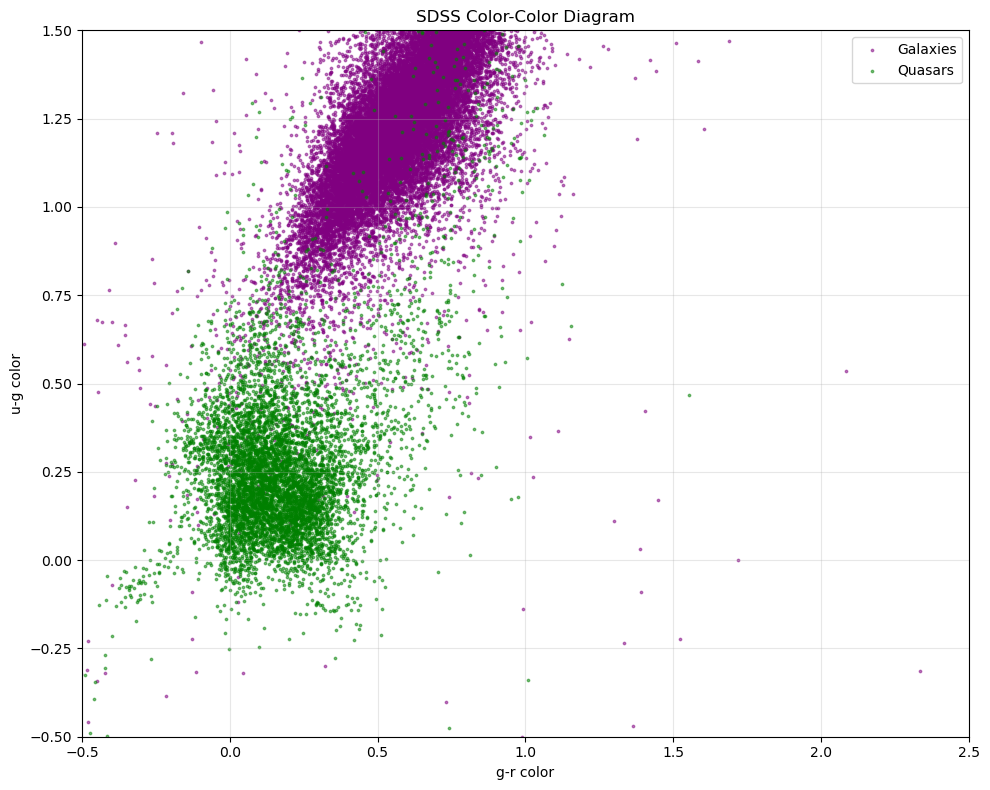

In [10]:
#part 2
plt.figure(figsize=(10, 8))

mask_galaxies = (spec_class == 'GALAXY')
plt.scatter(g_r[mask_galaxies], u_g[mask_galaxies], 
            s=3, c='purple', alpha=0.5, label='Galaxies')
mask_quasars = (spec_class == 'QSO')
plt.scatter(g_r[mask_quasars], u_g[mask_quasars], 
            s=3, c='green', alpha=0.5, label='Quasars')

plt.xlabel('g-r color')
plt.ylabel('u-g color')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.title('SDSS Color-Color Diagram')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sdss_color_color.png')
plt.show()


In [15]:
#part 3
from sklearn.model_selection import train_test_split
X = np.column_stack((u_g, g_r, r_i, i_z, redshift))

y = np.zeros(len(data), dtype=int)
y[spec_class == 'QSO'] = 1 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {np.sum(y_train == 0)} galaxies, {np.sum(y_train == 1)} quasars")
print(f"Test set: {np.sum(y_test == 0)} galaxies, {np.sum(y_test == 1)} quasars")




Training set: 34264 galaxies, 5736 quasars
Test set: 8544 galaxies, 1456 quasars


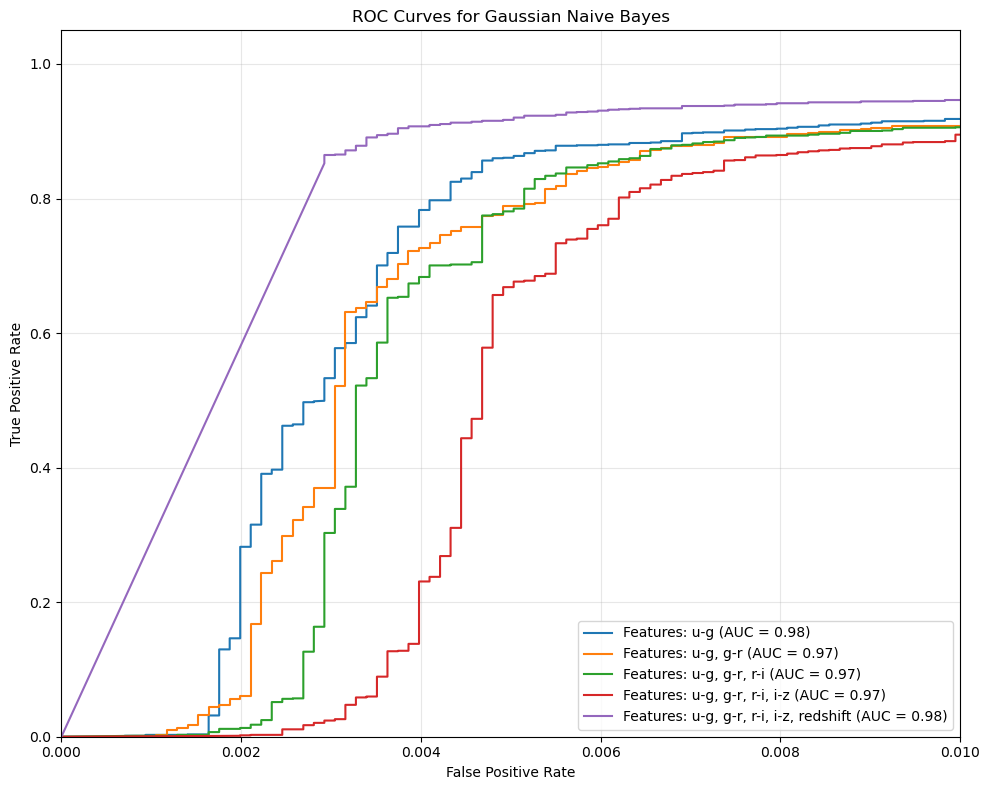

In [16]:
# Part 4: Gaussian Naive Bayes with ROC curves
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

features = ['u-g', 'g-r', 'r-i', 'i-z', 'redshift']
for i in range(1, X_train.shape[1] + 1):
    gnb = GaussianNB()
    gnb.fit(X_train[:, :i], y_train)
    quasar_prob_idx = list(gnb.classes_).index(1) 
    y_score = gnb.predict_proba(X_test[:, :i])[:, quasar_prob_idx]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Features: {", ".join(features[:i])} (AUC = {roc_auc:.2f})')

plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Gaussian Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

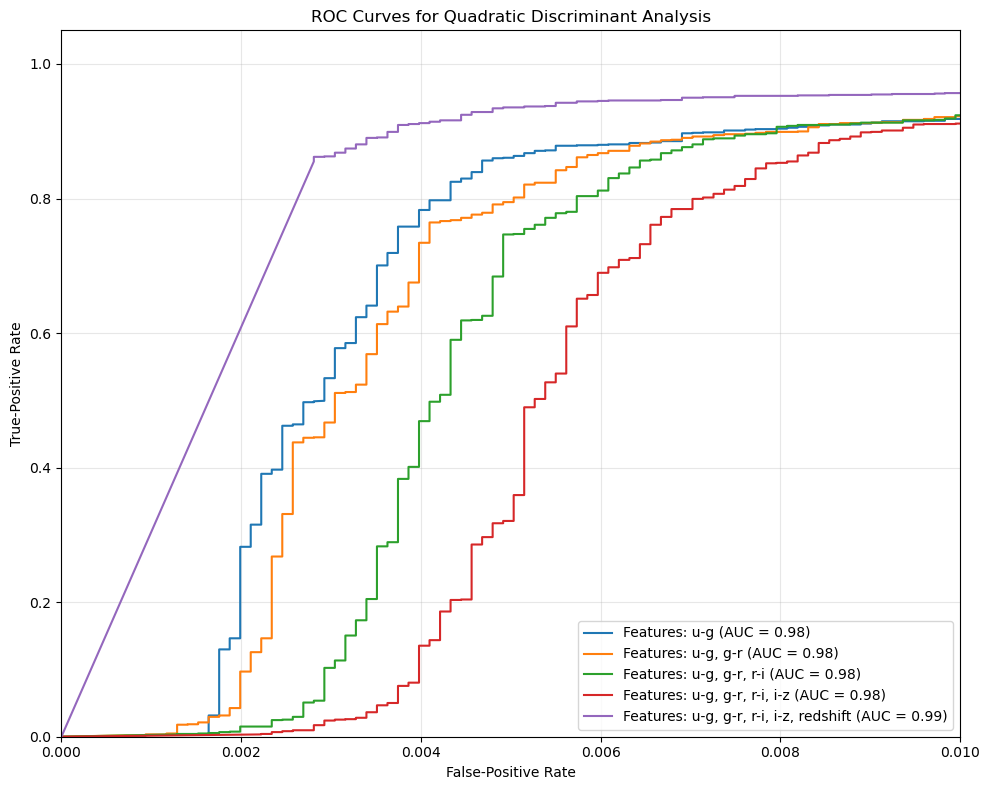

In [13]:
# Part 5: Quadratic Discriminant Analysis with ROC curves
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

plt.figure(figsize=(10, 8))

for i in range(1, X_train.shape[1] + 1):
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train[:, :i], y_train)
    quasar_prob_idx = list(qda.classes_).index(1)  
    y_score = qda.predict_proba(X_test[:, :i])[:, quasar_prob_idx]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Features: {", ".join(features[:i])} (AUC = {roc_auc:.2f})')

plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC Curves for Quadratic Discriminant Analysis')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\kdcow\miniconda3\envs\astr3300\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\kdcow\miniconda3\envs\astr3300\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\kdcow\miniconda3\envs\astr3300\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


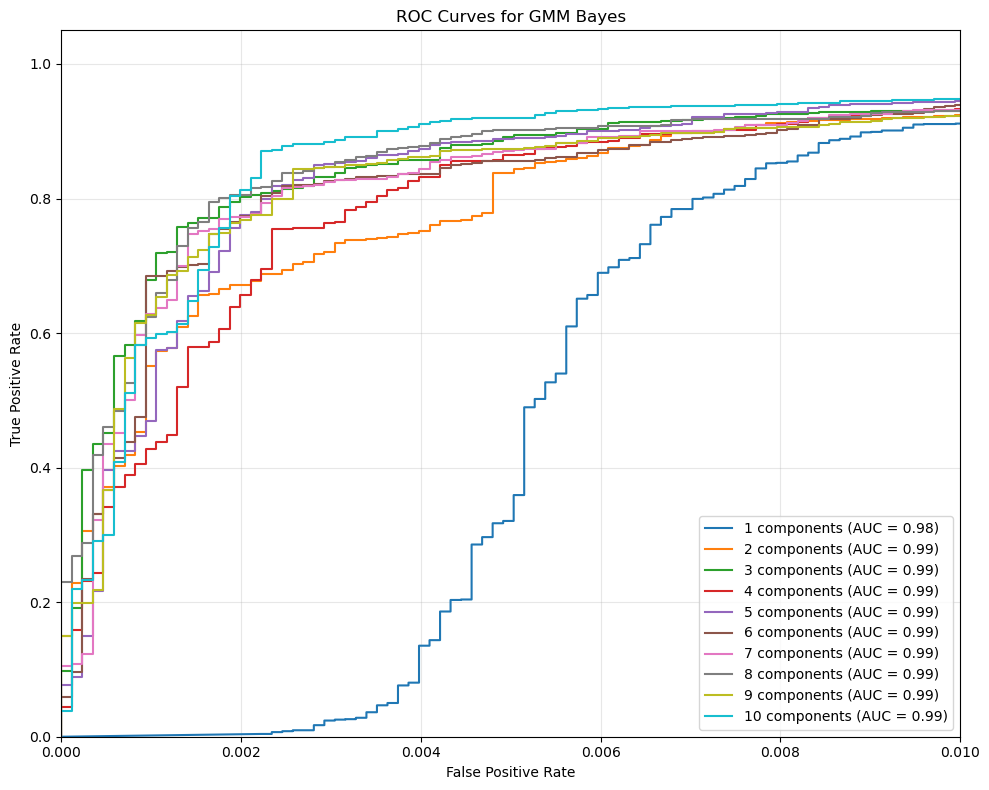

Best performance with 10 components (AUC = 0.99)


In [18]:
# Part 6: GMM Bayes with ROC curves
from astroML.classification import GMMBayes
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

X_train_colors = X_train[:, :4]
X_test_colors = X_test[:, :4]

best_auc = 0
best_components = 0

for n_components in range(1, 11): 
    gmm_bayes = GMMBayes(n_components=n_components, covariance_type='full', tol=1e-5)
    gmm_bayes.fit(X_train_colors, y_train)
    y_prob = gmm_bayes.predict_proba(X_test_colors)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_components = n_components
    plt.plot(fpr, tpr, label=f'{n_components} components (AUC = {roc_auc:.2f})')

plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GMM Bayes')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best performance with {best_components} components (AUC = {best_auc:.2f})")

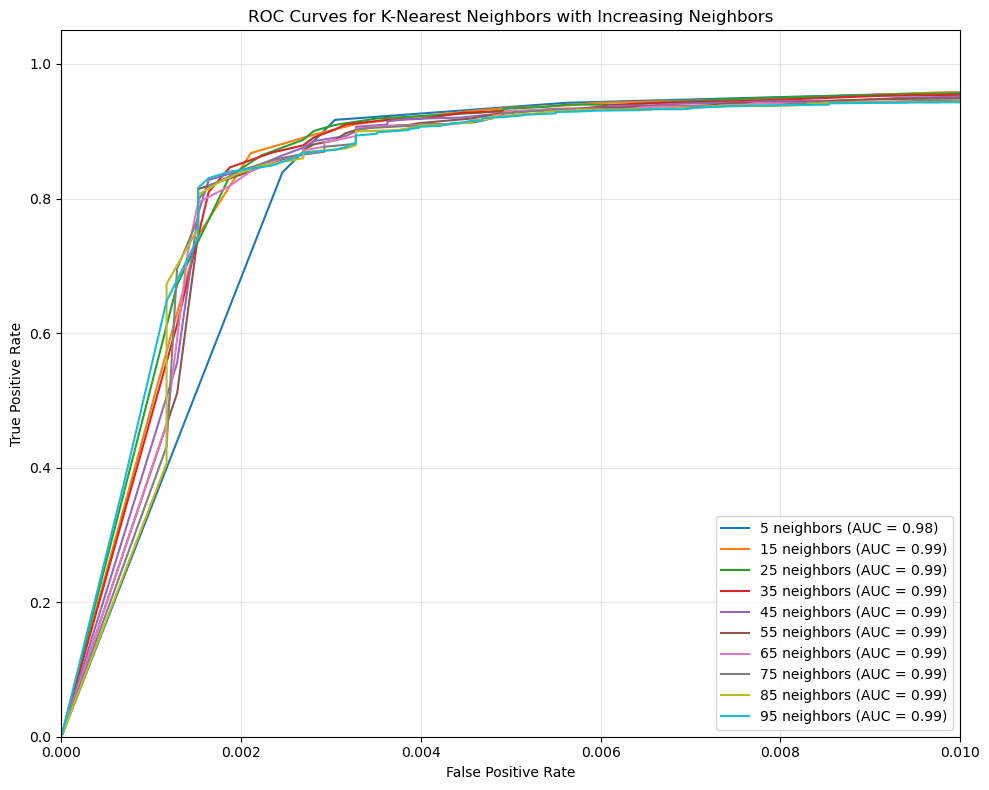

Best performance with 95 neighbors (AUC = 0.99)


In [19]:
#Part 7: K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
plt.figure(figsize=(10, 8))

best_k = 0

for n_neighbors in range(5, 101, 10):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_colors, y_train)
    y_prob = knn.predict_proba(X_test_colors)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_k = n_neighbors
    plt.plot(fpr, tpr, label=f'{n_neighbors} neighbors (AUC = {roc_auc:.2f})')
    
plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for K-Nearest Neighbors with Increasing Neighbors')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best performance with {best_k} neighbors (AUC = {best_auc:.2f})")

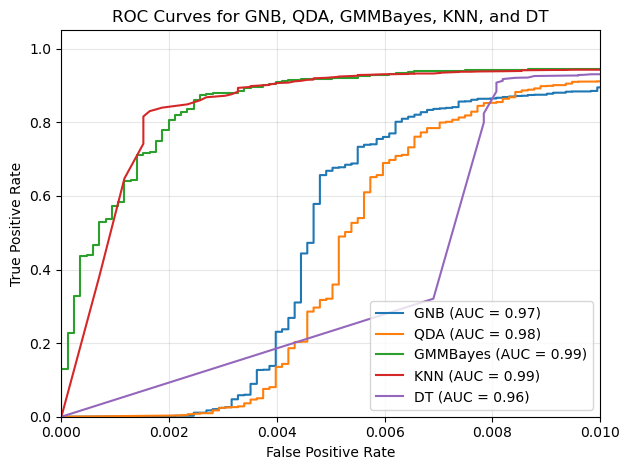

In [25]:
# Part 9: Plot ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT
from sklearn.tree import DecisionTreeClassifier
classifiers = {
    "GNB": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "GMMBayes": GMMBayes(n_components=best_components, covariance_type='full', tol=1e-5),
    "KNN": KNeighborsClassifier(n_neighbors=best_k),
    "DT": DecisionTreeClassifier(random_state=0, max_depth=12, criterion='entropy')
}

for name, clf in classifiers.items():
    clf.fit(X_train_colors, y_train)
    y_prob = clf.predict_proba(X_test_colors)[:, 1]  
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GNB, QDA, GMMBayes, KNN, and DT')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\kdcow\miniconda3\envs\astr3300\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\kdcow\miniconda3\envs\astr3300\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


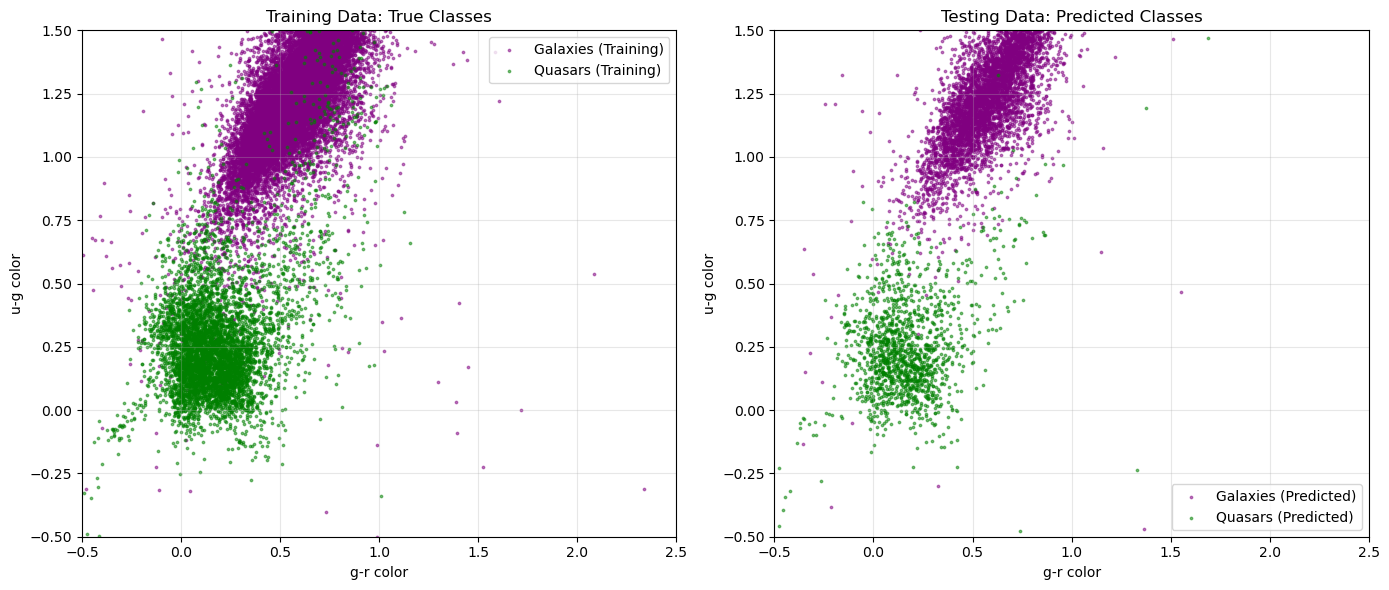

In [24]:
# Part 10: 2-panel plot GMMBayes
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(121)
mask_galaxies = (y_train == 0)
mask_quasars = (y_train == 1)
plt.scatter(X_train_colors[mask_galaxies, 1], X_train_colors[mask_galaxies, 0], 
            s=3, c='purple', alpha=0.5, label='Galaxies (Training)')
plt.scatter(X_train_colors[mask_quasars, 1], X_train_colors[mask_quasars, 0], 
            s=3, c='green', alpha=0.5, label='Quasars (Training)')
plt.xlabel('g-r color')
plt.ylabel('u-g color')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.title('Training Data: True Classes')
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(122)
best_classifier = GMMBayes(n_components=best_components, covariance_type='full', tol=1e-5)
best_classifier.fit(X_train_colors, y_train)
y_pred = best_classifier.predict(X_test_colors)

mask_galaxies_pred = (y_pred == 0)
mask_quasars_pred = (y_pred == 1)
plt.scatter(X_test_colors[mask_galaxies_pred, 1], X_test_colors[mask_galaxies_pred, 0], 
            s=3, c='purple', alpha=0.5, label='Galaxies (Predicted)')
plt.scatter(X_test_colors[mask_quasars_pred, 1], X_test_colors[mask_quasars_pred, 0], 
            s=3, c='green', alpha=0.5, label='Quasars (Predicted)')
plt.xlabel('g-r color')
plt.ylabel('u-g color')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.title('Testing Data: Predicted Classes')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<span style="color:green">NP: Correct! Good job!</span>